Figure 3 analysis
Performing ARU-E (Extractin part) showing that from robust FAT model we can obtain non-robust model

In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
# Specify aggregation method, number of clients, and dataset
setting, num_user = "FedAvg_adv", 40
exp = "cifar10"

# Load models for FAT and FedAvg - write down path to where weights are saved
save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/cifar10/250123_icml25/FAT/'
save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/cifar10/250123_icml25/FedAvg/'
# save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FAT_ep02/'
# save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FedAvg/'

# Attack parameters for performing PGD 
eps_attack = 4.0
eps_train = 4.5
step_size = 0.01
steps = 10

In [4]:
# Generate instance of aggregator that holds all clients, data and models and load relevant models in
try: # Skip loading if already loaded
    aggregator_og
except:
    aggregator_og, clients, args_ = set_args(setting, num_user,  experiment = exp) # Indicate dataset here

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator_og, args_)[0])
model_Fedavg = copy.deepcopy(import_model_weights(num_user, setting, save_path_FedAvg, aggregator_og, args_)[0])

# Obtain parameters for each layer
params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Just take the values of weights and bias for the model
desired_keys = params_FAT.keys() # [key for key in params_FAT.keys() if 'weight' in key or 'bias' in key] # 

==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 90.66it/s]


===> Initializing clients..


  0%|          | 0/40 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 40/40 [00:21<00:00,  1.89it/s]
/home/ubuntu/fedatk_unl_tj/aggregator.py:289: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious p

In [5]:
# Perform 50 rounds of full overfitting on benign data on 200R FAT model
num_rounds = 10
num_users = [1,3,5,10]


test_acc_gather = {}
adv_acc_gather = {}
test_acc_std_gather = {}
adv_acc_std_gather = {}

peturb_prop = 0.5
cutoff_round = 5


# save_path_FAT150 = '/home/ubuntu/fedatk_unl_tj/weights/cifar10/250123_icml25/FAT_R50/'

for num_user in num_users:
    aggregator, clients, args_ = set_args(setting, num_user,  experiment = exp)

    test_acc_gather[num_user] = []
    adv_acc_gather[num_user] = []
    test_acc_std_gather[num_user] = []
    adv_acc_std_gather[num_user] = []
    
    # Test performance of aggregator on data 
    aggregator.load_state(dir_path=save_path_FAT)
    aggregator.update_clients()
    
    # Trim number of clients
    aggregator.clients = aggregator.clients[0:num_user]
    aggregator.clients_weights = np.divide(aggregator.clients_weights[0:num_user],np.sum(aggregator.clients_weights[0:num_user].numpy()))
    aggregator.n_clients_per_round = num_user
    
    model_FAT = pull_model_from_agg(aggregator)
    model_FAT.eval()

    
    # Add standard deviation
    acc, adv_acc = get_adv_acc(aggregator_og, model_FAT)

    print("round", 0 ,"Test acc: ", np.mean(acc), "(", np.std(acc),")", "adv acc: ", 
                  np.mean(adv_acc), "(", np.std(adv_acc),")")
    test_acc_gather[num_user] += [np.mean(acc)]
    adv_acc_gather[num_user] += [np.mean(adv_acc)]
    test_acc_std_gather[num_user] += [np.std(acc)]
    adv_acc_std_gather[num_user] += [np.std(adv_acc)]
    
    # Setting evasion attack parameters
    x_min = torch.min(clients[0].adv_nn.dataloader.x_data)
    x_max = torch.max(clients[0].adv_nn.dataloader.x_data)
    atk_params = PGD_Params()
    atk_params.set_params(batch_size=1, iteration = 5,
                    target = -1, x_val_min = x_min, x_val_max = x_max,
                    step_size = 0.05, step_norm = "inf", eps = 4.5, eps_norm = 2)
    
    #  Assign proportion and attack params
    if True:
        for c in aggregator.clients:
            c.unlearning_flag = True
            
    for i in range(len(aggregator.clients)):
        aggregator.clients[i].set_adv_params(peturb_prop, atk_params)
        aggregator.clients[i].update_advnn()
        aggregator.clients[i].assign_advdataset()
    
    for round in range(1,num_rounds+1):
        
        aggregator.mix()
        model_overfit = pull_model_from_agg(aggregator)
        
        if round%1 == 0:
            
            if round <= cutoff_round:
                for i in range(len(aggregator.clients)):
                    aggregator.clients[i].set_adv_params(peturb_prop, atk_params)
                    aggregator.clients[i].update_advnn()
                    aggregator.clients[i].assign_advdataset()
            else:
                for i in range(len(aggregator.clients)):
                    aggregator.clients[i].reset_dataset()
                

            model_overfit.eval()
            acc, adv_acc = get_adv_acc(aggregator_og, model_overfit)

            print("round", round,"Test acc: ", np.mean(acc), "(", np.std(acc),")", "adv acc: ", 
                  np.mean(adv_acc), "(", np.std(adv_acc),")")
            test_acc_gather[num_user] += [np.mean(acc)]
            adv_acc_gather[num_user] += [np.mean(adv_acc)]
            test_acc_std_gather[num_user] += [np.std(acc)]
            adv_acc_std_gather[num_user] += [np.std(adv_acc)]

    del aggregator, clients, args_
    gc.collect()
    torch.cuda.empty_cache()


==> Clients initialization..
===> Building data iterators..


  0%|          | 0/80 [00:00<?, ?it/s]


===> Initializing clients..


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


round 0 Test acc:  0.8075000002980233 ( 0.06006507200952647 ) adv acc:  0.4196875005960464 ( 0.1039789466476375 )


/home/ubuntu/fedatk_unl_tj/learners/learner.py:192: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  loss = (loss_vec.T @ weights[indices]) / loss_vec.size(0)


round 1 Test acc:  0.7950000017881393 ( 0.06589527639236734 ) adv acc:  0.3934374988079071 ( 0.08619506874834922 )
round 2 Test acc:  0.6849999979138375 ( 0.07072172588336087 ) adv acc:  0.2756250001490116 ( 0.0607858716435281 )
round 3 Test acc:  0.49781249836087227 ( 0.09052310969657722 ) adv acc:  0.17000000071711838 ( 0.05908151231569392 )
round 4 Test acc:  0.3975000001490116 ( 0.0969132980199678 ) adv acc:  0.1253124999580905 ( 0.05487823798422127 )
round 5 Test acc:  0.4375000011175871 ( 0.10558616237178996 ) adv acc:  0.12843750049360098 ( 0.04601184436349026 )
round 6 Test acc:  0.44375000037252904 ( 0.10262187888138605 ) adv acc:  0.13718750067055224 ( 0.0610127740169039 )
round 7 Test acc:  0.4681250020861626 ( 0.1145626888460246 ) adv acc:  0.14156249968800694 ( 0.05689817461752131 )
round 8 Test acc:  0.47281250059604646 ( 0.10982541276139267 ) adv acc:  0.15156250004656613 ( 0.061757305251032624 )
round 9 Test acc:  0.46781250163912774 ( 0.10235078859741005 ) adv acc:  0.

  2%|▎         | 2/80 [00:00<00:00, 86.55it/s]


===> Initializing clients..


100%|██████████| 3/3 [00:01<00:00,  2.93it/s]


round 0 Test acc:  0.8050000071525574 ( 0.06589527469636172 ) adv acc:  0.4315624989569187 ( 0.09730699925555623 )
round 1 Test acc:  0.5534374967217446 ( 0.09057056703011937 ) adv acc:  0.17500000074505806 ( 0.05842998012407489 )
round 2 Test acc:  0.49906249567866323 ( 0.0830280163406145 ) adv acc:  0.11531250034458936 ( 0.034174130009317245 )
round 3 Test acc:  0.5181250020861625 ( 0.08366367025378832 ) adv acc:  0.13406250132247804 ( 0.03342289419098345 )
round 4 Test acc:  0.559375 ( 0.07545435687252716 ) adv acc:  0.13937500156462193 ( 0.04415438168764302 )
round 5 Test acc:  0.5715625002980232 ( 0.0781618629307662 ) adv acc:  0.13656250052154065 ( 0.04044551643908653 )
round 6 Test acc:  0.5756249979138375 ( 0.06970641876608068 ) adv acc:  0.14593749968335032 ( 0.04149430439717085 )
round 7 Test acc:  0.5912499971687794 ( 0.07635238979954799 ) adv acc:  0.1396874999627471 ( 0.040300385697828435 )
round 8 Test acc:  0.587812502682209 ( 0.07692770310870496 ) adv acc:  0.1440625004

  5%|▌         | 4/80 [00:00<00:00, 96.02it/s]


===> Initializing clients..


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


round 0 Test acc:  0.8065625041723251 ( 0.06863555960512163 ) adv acc:  0.4234374985098839 ( 0.10962248700223073 )
round 1 Test acc:  0.6656249985098839 ( 0.07804996989579759 ) adv acc:  0.20031249839812518 ( 0.05172700856424953 )
round 2 Test acc:  0.6121875017881393 ( 0.07595678606285762 ) adv acc:  0.16750000081956387 ( 0.05182603191452451 )
round 3 Test acc:  0.6603125013411045 ( 0.08935040606503679 ) adv acc:  0.18906249925494195 ( 0.048988796743540675 )
round 4 Test acc:  0.6474999964237214 ( 0.07011152036286673 ) adv acc:  0.15593750048428773 ( 0.0456709961181916 )
round 5 Test acc:  0.6568749994039536 ( 0.06811926510824837 ) adv acc:  0.18218749929219485 ( 0.04566244268445645 )
round 6 Test acc:  0.6915625005960464 ( 0.061261961566325365 ) adv acc:  0.18218750040978193 ( 0.0442725482256456 )
round 7 Test acc:  0.6971875041723251 ( 0.0614593051679355 ) adv acc:  0.1896874990314245 ( 0.050457864450935884 )
round 8 Test acc:  0.6909374982118607 ( 0.06626105504478774 ) adv acc:  0.

 11%|█▏        | 9/80 [00:00<00:00, 134.70it/s]


===> Initializing clients..


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


round 0 Test acc:  0.8021874994039535 ( 0.059613828964499294 ) adv acc:  0.4259375028312206 ( 0.10500697660853192 )
round 1 Test acc:  0.7103124976158142 ( 0.07870472222298575 ) adv acc:  0.26718749925494195 ( 0.06541260513031147 )
round 2 Test acc:  0.6568749986588955 ( 0.07770889188850451 ) adv acc:  0.19406250026077032 ( 0.04921155690360574 )
round 3 Test acc:  0.6412499979138374 ( 0.06381124065947338 ) adv acc:  0.1971874987706542 ( 0.05745157489034673 )
round 4 Test acc:  0.6675000056624413 ( 0.07978487088025335 ) adv acc:  0.18187499959021808 ( 0.04480426058996141 )
round 5 Test acc:  0.6871875047683715 ( 0.08180042120707492 ) adv acc:  0.18062499910593033 ( 0.047265042963464114 )
round 6 Test acc:  0.7021874994039535 ( 0.08477394034871506 ) adv acc:  0.1753124998882413 ( 0.048128042758419906 )
round 7 Test acc:  0.7121874958276748 ( 0.07253703511773546 ) adv acc:  0.18187499884516 ( 0.04078813295918602 )
round 8 Test acc:  0.7128125011920929 ( 0.07502539039520467 ) adv acc:  0.1

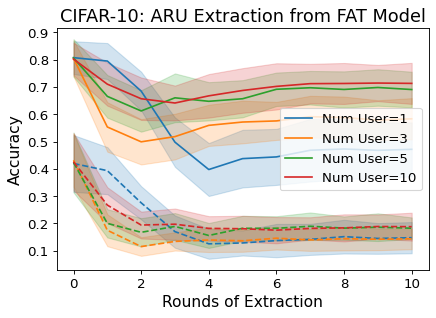

In [6]:

# Initialize a new figure
plt.figure(figsize=(6, 4), dpi=80)

# X-axis values: 0 to 30 in intervals of 5 (7 points)
x_values = np.arange(0, 11, 1)

# Define a colormap
colors = plt.get_cmap("tab10").colors

# Iterate over each num_user key
for i, num_user in enumerate(test_acc_gather.keys()):
    # Extract corresponding data for each num_user
    test_acc = test_acc_gather[num_user]
    adv_acc = adv_acc_gather[num_user]
    test_acc_std = test_acc_std_gather[num_user]
    adv_acc_std = adv_acc_std_gather[num_user]
    
    # Get the color for this line
    color = colors[i]
    
    # Plot test accuracy with standard deviation
    plt.plot(x_values, test_acc, label=f'Num User={num_user}', color=color)
    plt.fill_between(x_values, np.array(test_acc) - np.array(test_acc_std),
                     np.array(test_acc) + np.array(test_acc_std), color=color, alpha=0.2)
    
    # Plot adversarial accuracy with standard deviation (dotted line)
    plt.plot(x_values, adv_acc, linestyle='--', color=color)
    plt.fill_between(x_values, np.array(adv_acc) - np.array(adv_acc_std),
                     np.array(adv_acc) + np.array(adv_acc_std), color=color, alpha=0.2)

# Add title and labels with increased font size
plt.title('CIFAR-10: ARU Extraction from FAT Model', fontsize=16)
plt.xlabel('Rounds of Extraction', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

# Combine legend to remove duplicates and label clarity with larger font
plt.legend(loc='best', fontsize=12)

# Increase tick label font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# Show the plot
plt.show()